In [47]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/anomalies.json


In [48]:
import numpy as np
import pandas as pd
import scipy as sp
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.applications import vgg16
from keras.preprocessing.image import load_img , img_to_array , array_to_img , ImageDataGenerator
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.utils import *
from PIL import Image
import requests
from io import BytesIO
import os
import random
import pickle
import tqdm
import itertools
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report , accuracy_score , confusion_matrix

In [49]:
#reading the json file using pandas
data = pd.read_json('/kaggle/input/anomalies.json',lines = True)
#adding a column specifying images has a crack or not
data['label'] = data.annotation.apply(lambda x: x['labels'][0] if len(x['labels'])==1 else 'Crack')
data.head()


,content,annotation,extras,metadata,label
0,http://com.dataturks.a96-i23.open.s3.amazonaws...,"{'labels': ['no Crack'], 'note': ''}",NaN,"{'first_done_at': 1528371420000, 'last_updated...",no Crack
1,http://com.dataturks.a96-i23.open.s3.amazonaws...,"{'labels': ['Crack'], 'note': ''}",NaN,"{'first_done_at': 1528373761000, 'last_updated...",Crack
2,http://com.dataturks.a96-i23.open.s3.amazonaws...,"{'labels': ['Crack'], 'note': ''}",NaN,"{'first_done_at': 1528371146000, 'last_updated...",Crack
3,http://com.dataturks.a96-i23.open.s3.amazonaws...,"{'labels': ['Crack'], 'note': ''}",NaN,"{'first_done_at': 1528371734000, 'last_updated...",Crack
4,http://com.dataturks.a96-i23.open.s3.amazonaws...,"{'labels': ['no Crack'], 'note': ''}",NaN,"{'first_done_at': 1528372265000, 'last_updated...",no Crack


In [50]:
#preparing the images dataset
images = []
#fetching the images form the url provided in the dataset
for url in tqdm.tqdm(data['content']):
    res = requests.get(url)
    img = Image.open(BytesIO(res.content))
    img = img.resize((224,224))
    img_array = img_to_array(img)
    img_batch = np.expand_dims(img_array , axis = 0)
    images.append(img_batch.astype('float16'))
#stacking all the images together
images = np.vstack(images)
print(images.shape)

100%|██████████| 1428/1428 [03:23<00:00,  7.02it/s]


(1428, 224, 224, 3)


In [51]:
#importing the VGG16 model trained on large imagenet dataset, excluding false, so that we can connect it to our fully connected layer
out = vgg16.VGG16(weights='imagenet', include_top=False, input_shape = (224, 224, 3))

In [52]:
#printing out all the layers
for layer in out.layers:
    print(layer)


In [53]:
#freezing all the layers except last 8 layers with convolutuion blocks
#as out main objective is to use this model as a feature extractor
for layer in out.layers[:-8]:
    layer.trainable = False


In [54]:
#printing out the trainable and froze layers
for layer in out.layers:
    print(layer , layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x7f5241e3bc50> False
<keras.layers.convolutional.Conv2D object at 0x7f5241e3bf90> False
<keras.layers.convolutional.Conv2D object at 0x7f5241e3b250> False
<keras.layers.pooling.MaxPooling2D object at 0x7f56d6c25090> False
<keras.layers.convolutional.Conv2D object at 0x7f5241e38910> False
<keras.layers.convolutional.Conv2D object at 0x7f5241e37850> False
<keras.layers.pooling.MaxPooling2D object at 0x7f5241e34090> False
<keras.layers.convolutional.Conv2D object at 0x7f56d7f367d0> False
<keras.layers.convolutional.Conv2D object at 0x7f5241e31190> False
<keras.layers.convolutional.Conv2D object at 0x7f5241e2f4d0> False
<keras.layers.pooling.MaxPooling2D object at 0x7f5241e2cb50> False
<keras.layers.convolutional.Conv2D object at 0x7f5241e2b3d0> True
<keras.layers.convolutional.Conv2D object at 0x7f5241e29090> True
<keras.layers.convolutional.Conv2D object at 0x7f5241ea2390> True
<keras.layers.pooling.MaxPooling2D object at 0x7f5241ea2290> Tr

In [55]:
#preparing the labels(excluding the column from the dataset)
Y = (data.label.values == 'Crack')+0

In [56]:
#train test split
X_train, X_test, y_train, y_test = train_test_split(images, Y, random_state = 42, test_size=0.2)

In [57]:
x = out.output  #obtainig the output of vgg model feature extractor layer
x = GlobalAveragePooling2D()(x)     #average pooling, for dimensionality reduction , prevents overfitting
x = Dense(2, activation="softmax")(x)  #last layer provides probabilistic output using softmax function
from keras.losses import sparse_categorical_crossentropy    #using sparse categorical cross entropy loss because the labels are not one hot encoded
#loss_fn = SparseCategoricalCrossentropy()
#from keras.optimizers import Adam
import keras
opt = keras.optimizers.Adam(learning_rate=0.0001)

model = Model(out.input, x)
model.compile(loss = sparse_categorical_crossentropy, optimizer =opt , metrics=["accuracy"])

model.summary()

Model: "model_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0  

In [58]:
#IMAGE AUGMENTATION for better training and testing generalization


train_datagen = ImageDataGenerator(
        rescale = 1./255,
        horizontal_flip = True,
        fill_mode = "nearest",
        zoom_range = 0.3,
        width_shift_range = 0.3,
        height_shift_range=0.3,
        rotation_range=30
)

train_datagen.fit(X_train)

val_datagen = ImageDataGenerator(
        rescale = 1./255,
        horizontal_flip = True,
        fill_mode = "nearest",
        zoom_range = 0.3,
        width_shift_range = 0.3,
        height_shift_range=0.3,
        rotation_range=30
)
val_datagen.fit(X_test)

In [59]:
model2 = Model(out.input , x)
batch_size = 64
model2.compile(loss = sparse_categorical_crossentropy , optimizer = opt,
             metrics = ['accuracy'])
model2.fit(x = train_datagen.flow(X_train,y_train,batch_size = batch_size),
            steps_per_epoch = len(X_train)/batch_size,
                     validation_data = val_datagen.flow(X_test , y_test , batch_size = batch_size),
                     validation_steps = len(X_test)/batch_size,
                     epochs = 20
                    )

Epoch 1/20
18/17 [==============================] - 17s 928ms/step - loss: 0.5730 - accuracy: 0.6865 - val_loss: 0.5070 - val_accuracy: 0.8322
Epoch 2/20
18/17 [==============================] - 16s 899ms/step - loss: 0.3779 - accuracy: 0.8476 - val_loss: 0.2230 - val_accuracy: 0.8566
Epoch 3/20
18/17 [==============================] - 16s 913ms/step - loss: 0.3058 - accuracy: 0.8748 - val_loss: 0.4211 - val_accuracy: 0.8427
Epoch 4/20
18/17 [==============================] - 17s 941ms/step - loss: 0.2911 - accuracy: 0.8870 - val_loss: 0.2169 - val_accuracy: 0.8916
Epoch 5/20
18/17 [==============================] - 16s 892ms/step - loss: 0.2667 - accuracy: 0.8932 - val_loss: 0.2555 - val_accuracy: 0.8951
Epoch 6/20
18/17 [==============================] - 16s 913ms/step - loss: 0.2663 - accuracy: 0.8897 - val_loss: 0.1248 - val_accuracy: 0.9091
Epoch 7/20
18/17 [==============================] - 17s 945ms/step - loss: 0.2610 - accuracy: 0.8967 - val_loss: 0.3345 - val_accuracy: 0.8846

In [60]:
model2.save('anomalt_detection_image_vgg16_pretrained.h5')  #saving the model and its weights

In [98]:
#plotting the feature maps ot eh output activations of last convolution block of vgg16 model, where it focusses on the cracked parts of image
def plot_activation(img):  
    #adding a new dimension to the image as it is a 3d tensor, no batch size axis included
    pred = model.predict(img[np.newaxis,:,:,:])
    #getting the class with max probablity
    pred_class = np.argmax(pred)

    weights = model.layers[-1].get_weights()[0] #weights last classification layer
    #Extracting the class weights out of weights matrix
    class_weights = weights[:, pred_class]
    #defining a model with last convolution block as the final output layer of the model
    intermediate = Model(model.input, model.get_layer("block5_conv3").output)
    #feeding the image into the model for prediction and activation outputs
    conv_output = intermediate.predict(img[np.newaxis,:,:,:])
    #remove the single dimensions from the image array::> like::> (1,2,1) on squeezing becomes (2,) i.e. single dimensions are removed
    conv_output = np.squeeze(conv_output)
    #getting the position of activated parts 
    h = int(img.shape[0]/conv_output.shape[0])
    w = int(img.shape[1]/conv_output.shape[1])
    #defining the accent of activated area and image
    activation_maps = sp.ndimage.zoom(conv_output, (h, w, 1), order=1)
    #getting activation on the image(if only this is plotted, image objects will dissapper)
    out = np.dot(activation_maps.reshape((img.shape[0]*img.shape[1], 512)), class_weights).reshape(img.shape[0],img.shape[1])
    #plotting the original image and then activations image is overlapped on the orginal image
    plt.imshow(img.astype('float32').reshape(img.shape[0],img.shape[1],3))
    plt.imshow(out, cmap='jet', alpha=0.35)
    #display with the title crack or not cracked
    plt.title('Crack' if pred_class == 1 else 'No Crack')

   

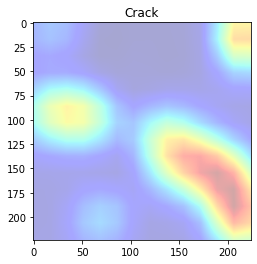

In [99]:

plot_activation(X_test[134]/255)

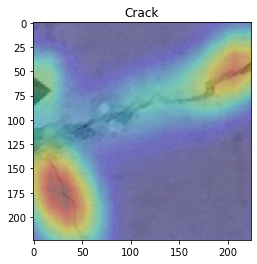

In [91]:
plot_activation(X_test[202]/255)

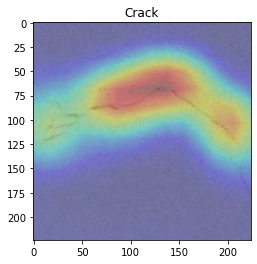

In [93]:
for i in range(1,5):
    plot_activation(X_test[i]/255)

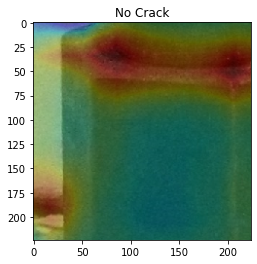

In [95]:
plot_activation(X_train[1]/255)